# 2.2: Two-Body Potential Energy Surface

Next, we will parameterize the "physical baseline" ($V_{phys}$) of the PEF.

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [11]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Parallel-Bias Metadynamics Configuration Generation

In [3]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2 = read_system(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O = read_system(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O)

dimer_struture = read_systems(definition_CH3NH2_H2O, paths.clusters.CH3NH2_H2O)[0]

In [19]:
calculator = Psi4Calculator("HF", "STO-3G", log_directory=f"{paths.logs}")

In [ ]:
vibrational_modes_CH3NH2_H2O = calculate_vibrational_modes(
        dimer_struture,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.vibrational_modes_CH3NH2_H2O,
        16,
        32000
)
write_vibrational_modes(paths.PIP_CH3NH2_H2O.vibrational_modes_CH3NH2_H2O, vibrational_modes_CH3NH2_H2O)

In [4]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        dimer_struture
)

In [5]:
bond_params

{('A', 'B'): (30, 1.0899486044930917),
 ('A', 'C'): (50, 1.4870216225214954),
 ('C', 'D'): (30, 1.0327059940972794),
 ('E', 'F'): (30, 0.9893584176464172)}

In [6]:
angle_params

{('B', 'A', 'B'): (10, 108.41073323121982),
 ('B', 'A', 'C'): (10, 110.49967007185985),
 ('D', 'C', 'D'): (10, 104.64302138506169),
 ('A', 'C', 'D'): (10, 107.6893579030835),
 ('F', 'E', 'F'): (10, 100.26000827451064)}

In [7]:
nonbonded_params

{'A': (0.03, 2.4),
 'B': (0.01, 1.2),
 'C': (0.03, 2.4),
 'D': (0.01, 1.2),
 'E': (0.03, 2.4),
 'F': (0.01, 1.2)}

In [8]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [16]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O
)

PBMetaD already completed. Will not rerun!
Converting PBMetaD trajectory to XYZ...


In [17]:
split_pool(
        definition_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        pool_size=500000,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [28]:
pbmetad_configs_CH3NH2_H2O = perform_fps(
        definition_CH3NH2_H2O,
        dimer_struture,
        vibrational_modes_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        num_pool_configs=500000-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=1000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O,
        num_threads=16
)

Number of permutations: 24
Beginning featurization...
Featurization progress: |====================================================================================================| - 399800/399800
Featurized 399800 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 425
Completed round 2 fps, selected 425 configs.


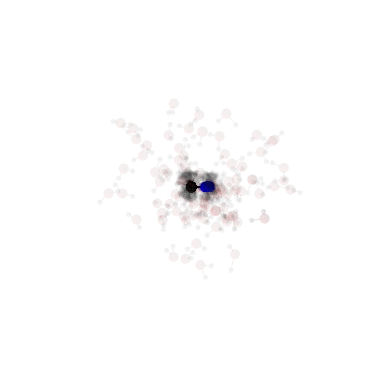

In [29]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

In [33]:
write_systems(paths.PIP_CH3NH2_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O)